In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Predict Student Results/Code
!ls

/content/drive/MyDrive/Predict Student Results/Code
Clean_data.ipynb  Data.csv  EDA.ipynb  test.csv  train.csv


In [3]:
!pip install --quiet shap==0.39.0

     |████████████████████████████████| 356 kB 5.1 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("Data.csv")

In [6]:
df

,ID,Nganh,Gioi tinh,Doi tuong,Khu vuc,Khoi TS,Diem TS,Hoc Ky,DKHK,TBHK,TCTL,TBTL,XLHV,Diem TN,KETQUA
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20,1,22,2.6,22,2.6,NaN,3.35,Tốt nghiệp Giỏi - 4 năm
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20,1,22,2.5,19,2.5,NaN,2.55,Tốt nghiệp Khá - 4 năm
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20,1,22,2.8,22,2.8,NaN,3.02,Tốt nghiệp Khá - 4 năm
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20,1,22,2.25,19,2.25,NaN,2.52,Tốt nghiệp Khá - 4 năm
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20,1,22,2.2,22,2.2,NaN,2.09,Tốt nghiệp Trung bình - 4 năm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198372,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.0,6,24,3.13,122,3.24,NaN,3.24,Tốt nghiệp Giỏi - 4 năm
198373,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.0,7,3,2.33,131,3.18,NaN,3.24,Tốt nghiệp Giỏi - 4 năm
198374,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,5,18,3.33,87,2.96,NaN,3.21,Tốt nghiệp Giỏi - 4 năm
198375,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,6,21,3.57,108,3.09,NaN,3.21,Tốt nghiệp Giỏi - 4 năm


In [7]:
df.shape

(198377, 15)

In [8]:
df.columns

Index(['ID', 'Nganh', 'Gioi tinh', 'Doi tuong', 'Khu vuc', 'Khoi TS',
       'Diem TS', 'Hoc Ky', 'DKHK', 'TBHK', 'TCTL', 'TBTL', 'XLHV', 'Diem TN',
       'KETQUA'],
      dtype='object')

In [9]:
# renaming columns
col_map={
    'ID': 'id',
    'Nganh': 'nganh',
    'Gioi tinh': 'gioi_tinh',
    'Doi tuong': 'doi_tuong',
    'Khu vuc': 'khu_vuc',
    'Khoi TS': 'khoi_ts',
    'Diem TS': 'diem_ts',
    'Hoc Ky': 'hoc_ky',
    'DKHK': 'dkhk',
    'TBHK': 'tbhk',
    'TCTL': 'tctl',
    'TBTL': 'tbtl',
    'XLHV': 'xlhv',
    'Diem TN': 'diem_tn',
    'KETQUA': 'ket_qua'
}
df.rename(columns=col_map, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198377 entries, 0 to 198376
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         198377 non-null  object
 1   nganh      198377 non-null  object
 2   gioi_tinh  198377 non-null  object
 3   doi_tuong  198377 non-null  object
 4   khu_vuc    198377 non-null  object
 5   khoi_ts    198377 non-null  object
 6   diem_ts    198232 non-null  object
 7   hoc_ky     198377 non-null  object
 8   dkhk       198377 non-null  object
 9   tbhk       198377 non-null  object
 10  tctl       198186 non-null  object
 11  tbtl       198377 non-null  object
 12  xlhv       15456 non-null   object
 13  diem_tn    198377 non-null  object
 14  ket_qua    198377 non-null  object
dtypes: object(15)
memory usage: 22.7+ MB


In [11]:
df.dtypes

id           object
nganh        object
gioi_tinh    object
doi_tuong    object
khu_vuc      object
khoi_ts      object
diem_ts      object
hoc_ky       object
dkhk         object
tbhk         object
tctl         object
tbtl         object
xlhv         object
diem_tn      object
ket_qua      object
dtype: object

In [12]:
df['doi_tuong'].unique()

array(['0', '6', '4', '1', '5', '7', 'Doi tuong', '3', 0, 1, 3, 6, 4],
      dtype=object)

In [13]:
df['doi_tuong'].value_counts()

0            183542
1              7219
6              4470
0              1631
4               709
5               625
1               112
3                30
6                14
7                10
3                 8
4                 4
Doi tuong         3
Name: doi_tuong, dtype: int64

In [14]:
df['doi_tuong'] = df['doi_tuong'].replace(0,'0')
df['doi_tuong'] = df['doi_tuong'].replace(1,'1')
df['doi_tuong'] = df['doi_tuong'].replace(3,'3')
df['doi_tuong'] = df['doi_tuong'].replace(6,'6')
df['doi_tuong'] = df['doi_tuong'].replace(4,'4')
df.drop(df[df['doi_tuong'] == 'Doi tuong'].index, inplace=True)

In [15]:
df['doi_tuong'].value_counts()

0    185173
1      7331
6      4484
4       713
5       625
3        38
7        10
Name: doi_tuong, dtype: int64

In [16]:
df['diem_ts'].unique()

array(['20', '19', '20.5', '24.5', '25', '23.5', '22.5', '25.5', '24',
       '23', '21', '26', '27.5', '27', '22', '26.5', '21.5', '28.5', '28',
       '18', '19.5', '19.2', '18.5', '17.5', '17', '16.5', '16', '22.25',
       '23.25', '29', '23.7', '30', '21.75', '21.25', '29.5', '20.25',
       '19.75', '20.75', '22.75', '24.75', '23.75', '19.25', '26.25',
       '24.25', '25.25', '25.75', '26.75', '27.25', '16.25', '16.75',
       '18.75', '17.75', '17.25', '18.25', '27.75', '14.5', '15.5', '15',
       '20.52', '14', '21.2', '24.2', '17.2', '17.7', '20.2', '18.7',
       '18.2', '16.7', '22.7', '19.7', '15.7', '16.2', '15.2', '22.2',
       '20.7', '21.7', '21.92', '23.15', '21.3', '21.6', '21.95', '22.65',
       '22.3', '21.05', '22.4', '22.05', '22.85', '21.15', '20.85',
       '21.38', '21.53', '21.35', '21.55', '23.3', '18.85', '21.85',
       '23.2', '21.65', '21.58', '22.45', '24.1', '23.23', '22.1',
       '21.45', '22.8', '24.4', '21.1', '21.4', '21.8', '22.73', '20.78',
 

In [17]:
# Chuyển các chỗ nhập điểm 0 thành missing value
df.loc[df['diem_ts'] == '0','diem_ts'] = np.nan

In [18]:
df['diem_ts'] = pd.to_numeric(df['diem_ts'])

In [19]:
df['diem_ts'].unique()

array([20.  , 19.  , 20.5 , 24.5 , 25.  , 23.5 , 22.5 , 25.5 , 24.  ,
       23.  , 21.  , 26.  , 27.5 , 27.  , 22.  , 26.5 , 21.5 , 28.5 ,
       28.  , 18.  , 19.5 , 19.2 , 18.5 , 17.5 , 17.  , 16.5 , 16.  ,
       22.25, 23.25, 29.  , 23.7 , 30.  , 21.75, 21.25, 29.5 , 20.25,
       19.75, 20.75, 22.75, 24.75, 23.75, 19.25, 26.25, 24.25, 25.25,
       25.75, 26.75, 27.25, 16.25, 16.75, 18.75, 17.75, 17.25, 18.25,
       27.75, 14.5 , 15.5 , 15.  , 20.52, 14.  , 21.2 , 24.2 , 17.2 ,
       17.7 , 20.2 , 18.7 , 18.2 , 16.7 , 22.7 , 19.7 , 15.7 , 16.2 ,
       15.2 , 22.2 , 20.7 , 21.7 , 21.92, 23.15, 21.3 , 21.6 , 21.95,
       22.65, 22.3 , 21.05, 22.4 , 22.05, 22.85, 21.15, 20.85, 21.38,
       21.53, 21.35, 21.55, 23.3 , 18.85, 21.85, 23.2 , 21.65, 21.58,
       22.45, 24.1 , 23.23, 22.1 , 21.45, 22.8 , 24.4 , 21.1 , 21.4 ,
       21.8 , 22.73, 20.78, 22.95, 22.6 , 20.68, 23.8 , 23.65, 23.03,
       24.85, 22.35, 23.35, 23.1 , 22.55, 22.15, 24.15, 19.15, 20.9 ,
       19.55, 22.13,

In [20]:
print((df['diem_ts'] == 0).sum())
print(df['diem_ts'].isna().sum())

0
653


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198374 entries, 0 to 198376
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         198374 non-null  object 
 1   nganh      198374 non-null  object 
 2   gioi_tinh  198374 non-null  object 
 3   doi_tuong  198374 non-null  object 
 4   khu_vuc    198374 non-null  object 
 5   khoi_ts    198374 non-null  object 
 6   diem_ts    197721 non-null  float64
 7   hoc_ky     198374 non-null  object 
 8   dkhk       198374 non-null  object 
 9   tbhk       198374 non-null  object 
 10  tctl       198183 non-null  object 
 11  tbtl       198374 non-null  object 
 12  xlhv       15453 non-null   object 
 13  diem_tn    198374 non-null  object 
 14  ket_qua    198374 non-null  object 
dtypes: float64(1), object(14)
memory usage: 24.2+ MB


In [22]:
df['hoc_ky'].unique()

array(['1', '3', '5', '2', '4', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '20', '22', '23',
       5, 6, 7, 8], dtype=object)

In [23]:
df['hoc_ky'] = df['hoc_ky'].replace(5,'5')
df['hoc_ky'] = df['hoc_ky'].replace(6,'6')
df['hoc_ky'] = df['hoc_ky'].replace(7,'7')
df['hoc_ky'] = df['hoc_ky'].replace(8,'8')

In [24]:
df['hoc_ky'].value_counts()

6     25802
5     25777
7     25221
3     24447
4     24346
1     22307
2     22089
8     19463
9      2898
10     2314
11     1484
12     1040
13      643
14      265
15       97
16       45
18       30
21       27
19       23
22       23
20       20
17       12
23        1
Name: hoc_ky, dtype: int64

In [25]:
df['hoc_ky'] = df['hoc_ky'].replace(['9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '21', '20', '22', '23'], 'After semester 8')

In [26]:
df['hoc_ky'].value_counts()

6                   25802
5                   25777
7                   25221
3                   24447
4                   24346
1                   22307
2                   22089
8                   19463
After semester 8     8922
Name: hoc_ky, dtype: int64

In [27]:
df['dkhk'].unique()

array(['22', '16', '19', '13', '0', '25', '28', '18', '17', '23', '20',
       '26', '10', '4', '32', '29', '21', '24', '27', '15', '31', '12',
       '30', '9', '7', '33', '35', '34', '6', '3', '36', '39', '37', '14',
       '40', '43', '11', '44', '1', '38', '2', '42', '45', '46', '8', '5',
       '47', '72', '50', '49', '48', '52', '41', '51', '54', '55', '53',
       17, 18, 21, 7, 6, 3, 19, 15, 20, 23, 1, 16, 24, 22, 4, 12, 27, 0,
       2, 25, 9, 5, 14, 10, 31, 13, 28, 26, 29], dtype=object)

In [28]:
df['dkhk'] = pd.to_numeric(df['dkhk'])
df['tbhk'] = pd.to_numeric(df['tbhk'])
df['tctl'] = pd.to_numeric(df['tctl'])
df['tbtl'] = pd.to_numeric(df['tbtl'])

In [29]:
df['dkhk'].unique()

array([22, 16, 19, 13,  0, 25, 28, 18, 17, 23, 20, 26, 10,  4, 32, 29, 21,
       24, 27, 15, 31, 12, 30,  9,  7, 33, 35, 34,  6,  3, 36, 39, 37, 14,
       40, 43, 11, 44,  1, 38,  2, 42, 45, 46,  8,  5, 47, 72, 50, 49, 48,
       52, 41, 51, 54, 55, 53])

In [30]:
df.describe(include=['O']).T

,count,unique,top,freq
id,198374,27500,A06352,18
nganh,198374,12,Ngân hàng,59195
gioi_tinh,198374,2,Nữ,141357
doi_tuong,198374,7,0,185173
khu_vuc,198374,4,2NT,70028
khoi_ts,198374,6,A00,151068
hoc_ky,198374,9,6,25802
xlhv,15453,2,Cảnh báo,14766
diem_tn,198374,344,0,22159
ket_qua,198374,46,Tốt nghiệp Khá - 4 năm,94897


In [31]:
df.isna().sum()

id                0
nganh             0
gioi_tinh         0
doi_tuong         0
khu_vuc           0
khoi_ts           0
diem_ts         653
hoc_ky            0
dkhk              0
tbhk              0
tctl            191
tbtl              0
xlhv         182921
diem_tn           0
ket_qua           0
dtype: int64

In [32]:
# print duplicates
print("Number of duplicates: ", df.duplicated().sum())
print("Unique values per column:")
df.nunique()

Number of duplicates:  2414
Unique values per column:


id           27500
nganh           12
gioi_tinh        2
doi_tuong        7
khu_vuc          4
khoi_ts          6
diem_ts        279
hoc_ky           9
dkhk            57
tbhk           350
tctl           154
tbtl           277
xlhv             2
diem_tn        344
ket_qua         46
dtype: int64

In [33]:
df.head()

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.60,22.0,2.60,NaN,3.35,Tốt nghiệp Giỏi - 4 năm
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.50,19.0,2.50,NaN,2.55,Tốt nghiệp Khá - 4 năm
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.80,22.0,2.80,NaN,3.02,Tốt nghiệp Khá - 4 năm
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20.0,1,22,2.25,19.0,2.25,NaN,2.52,Tốt nghiệp Khá - 4 năm
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20.0,1,22,2.20,22.0,2.20,NaN,2.09,Tốt nghiệp Trung bình - 4 năm


In [34]:
df['ket_qua'] = df['ket_qua'].replace(['Tốt nghiệp Trung bình- 5 năm', 'Tốt nghiệp Trung bình- 4,5 năm'], ['Tốt nghiệp Trung bình - 5 năm', 'Tốt nghiệp Trung bình - 4,5 năm'])

In [35]:
df['ket_qua'].unique()

array(['Tốt nghiệp Giỏi - 4 năm', 'Tốt nghiệp Khá - 4 năm',
       'Tốt nghiệp Trung bình - 4 năm', 'Tốt nghiệp Trung bình - 5,5 năm',
       'Tốt nghiệp Xuất sắc - 4 năm', 'Tốt nghiệp Trung bình - 5 năm',
       'Tốt nghiệp Giỏi - 3 năm', 'Tốt nghiệp Trung bình - 4,5 năm',
       'Buộc thôi học', 'Tốt nghiệp Khá - 5 năm',
       'Tốt nghiệp Khá - 4,5 năm', 'Tốt nghiệp Trung bình - 6,5 năm',
       'Thôi học', 'Tốt nghiệp Trung bình - 6 năm',
       'Tốt nghiệp Khá - 6 năm', 'Tốt nghiệp Khá - 5,5 năm',
       'Tốt nghiệp Trung bình - 8,5 năm', 'Tốt nghiệp Khá - 6,5 năm',
       'Tốt nghiệp Giỏi - 4,5 năm', 'Tốt nghiệp Trung bình - 3 năm',
       'Tốt nghiệp Xuất sắc - 4,5 năm', 'Tốt nghiệp Khá - 3 năm',
       'Tốt nghiệp Trung bình - 7 năm', 'Tốt nghiệp Trung bình - 8 năm',
       'Tốt nghiệp Giỏi - 5 năm', 'Tốt nghiệp Khá - 8 năm',
       'Tốt nghiệp Trung bình - 7,5 năm', 'Tốt nghiệp Khá - 7 năm',
       'Tốt nghiệp Khá - 3,5 năm', 'Tốt nghiệp Giỏi - 3,5 năm',
       'Tốt nghiệp Xuấ

In [36]:
drop_index = df[(df['ket_qua'] == 'Buộc thôi học') | (df['ket_qua'] == 'Thôi học') | (df['ket_qua'] == 'Chuyển trường') | (df['ket_qua'] == 'Còn học') | \
                (df['ket_qua'] == 'Nghỉ học tạm thời')| (df['ket_qua'] == '#REF!')].index
df.drop(drop_index, inplace=True)

In [37]:
df['ket_qua'].unique()

array(['Tốt nghiệp Giỏi - 4 năm', 'Tốt nghiệp Khá - 4 năm',
       'Tốt nghiệp Trung bình - 4 năm', 'Tốt nghiệp Trung bình - 5,5 năm',
       'Tốt nghiệp Xuất sắc - 4 năm', 'Tốt nghiệp Trung bình - 5 năm',
       'Tốt nghiệp Giỏi - 3 năm', 'Tốt nghiệp Trung bình - 4,5 năm',
       'Tốt nghiệp Khá - 5 năm', 'Tốt nghiệp Khá - 4,5 năm',
       'Tốt nghiệp Trung bình - 6,5 năm', 'Tốt nghiệp Trung bình - 6 năm',
       'Tốt nghiệp Khá - 6 năm', 'Tốt nghiệp Khá - 5,5 năm',
       'Tốt nghiệp Trung bình - 8,5 năm', 'Tốt nghiệp Khá - 6,5 năm',
       'Tốt nghiệp Giỏi - 4,5 năm', 'Tốt nghiệp Trung bình - 3 năm',
       'Tốt nghiệp Xuất sắc - 4,5 năm', 'Tốt nghiệp Khá - 3 năm',
       'Tốt nghiệp Trung bình - 7 năm', 'Tốt nghiệp Trung bình - 8 năm',
       'Tốt nghiệp Giỏi - 5 năm', 'Tốt nghiệp Khá - 8 năm',
       'Tốt nghiệp Trung bình - 7,5 năm', 'Tốt nghiệp Khá - 7 năm',
       'Tốt nghiệp Khá - 3,5 năm', 'Tốt nghiệp Giỏi - 3,5 năm',
       'Tốt nghiệp Xuất sắc - 3,5 năm', 'Tốt nghiệp Xuất s

In [58]:
# df.drop('ket_qua', axis=1, inplace=True)
# df.drop('nam_tn', axis=1, inplace=True)

In [39]:
df['ket_qua_tn'] = df["ket_qua"].str.split(" - ").str[0]
df["nam_tn"] = df["ket_qua"].str.split(" - ").str[1]

In [45]:
df["nam_tn"] = df["nam_tn"].str.split(" ").str[0]

In [46]:
df.head()

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua,ket_qua_tn,nam_tn
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.60,22.0,2.60,NaN,3.35,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.50,19.0,2.50,NaN,2.55,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20.0,1,22,2.80,22.0,2.80,NaN,3.02,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20.0,1,22,2.25,19.0,2.25,NaN,2.52,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20.0,1,22,2.20,22.0,2.20,NaN,2.09,Tốt nghiệp Trung bình - 4 năm,Tốt nghiệp Trung bình,4


In [47]:
df['nam_tn'].unique()

array(['4', '5,5', '5', '3', '4,5', '6,5', '6', '8,5', '7', '8', '7,5',
       '3,5', '2,5', ''], dtype=object)

In [48]:
df['nam_tn'].value_counts()

4      148080
4,5     12090
5        6822
6        3411
5,5      3189
6,5      1028
3,5       439
7         317
3         274
8          87
7,5        82
           14
8,5        12
2,5         5
Name: nam_tn, dtype: int64

In [49]:
df.drop(df[df['nam_tn'] == ''].index, inplace=True)

In [55]:
# Chuyển '4,5' sag '4.5'
str_lst = []
float_lst = []
for value in df['nam_tn'].unique():
    if ',' in value:
        str_lst.append(value)
        new_value = value.replace(',', '.')
        float_lst.append(new_value)

print(str_lst)
print(float_lst)

['5,5', '4,5', '6,5', '8,5', '7,5', '3,5', '2,5']
['5.5', '4.5', '6.5', '8.5', '7.5', '3.5', '2.5']


In [56]:
df['nam_tn'] = df['nam_tn'].replace(str_lst, float_lst)
df['nam_tn'] = pd.to_numeric(df['nam_tn'])

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175836 entries, 0 to 198376
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  object 
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        3784 non-null    object 
 13  diem_tn     175836 non-null  object 
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(5), int64(1), object(10)
memory usage: 26.8+ MB


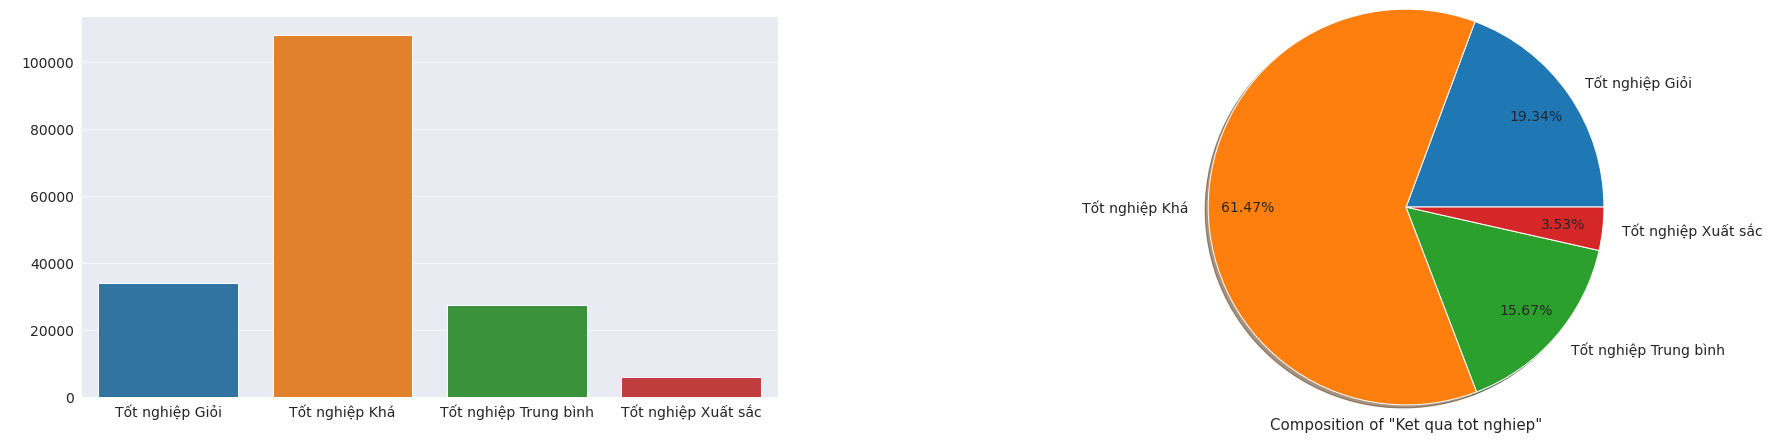

In [41]:
# checking the target
plt.figure(figsize=(30,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["ket_qua_tn"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(df["ket_qua_tn"].value_counts(sort = False),
        labels=list(df["ket_qua_tn"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Ket qua tot nghiep"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
df['nganh'].value_counts()

Ngân hàng                     53092
Kế toán doanh nghiệp          40581
Tài chính                     35572
Ngôn ngữ Anh                  11777
Quản trị kinh doanh            9762
Hệ thống thông tin quản lý     8826
Kinh doanh quốc tế             6649
Quản trị doanh nghiệp          5617
Quản trị marketing             2443
Luật kinh tế                   1521
Kinh doanh chứng khoán            6
Thanh toán quốc tế                4
Name: nganh, dtype: int64

In [ ]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['id', 'diem_tn', 'ket_qua'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

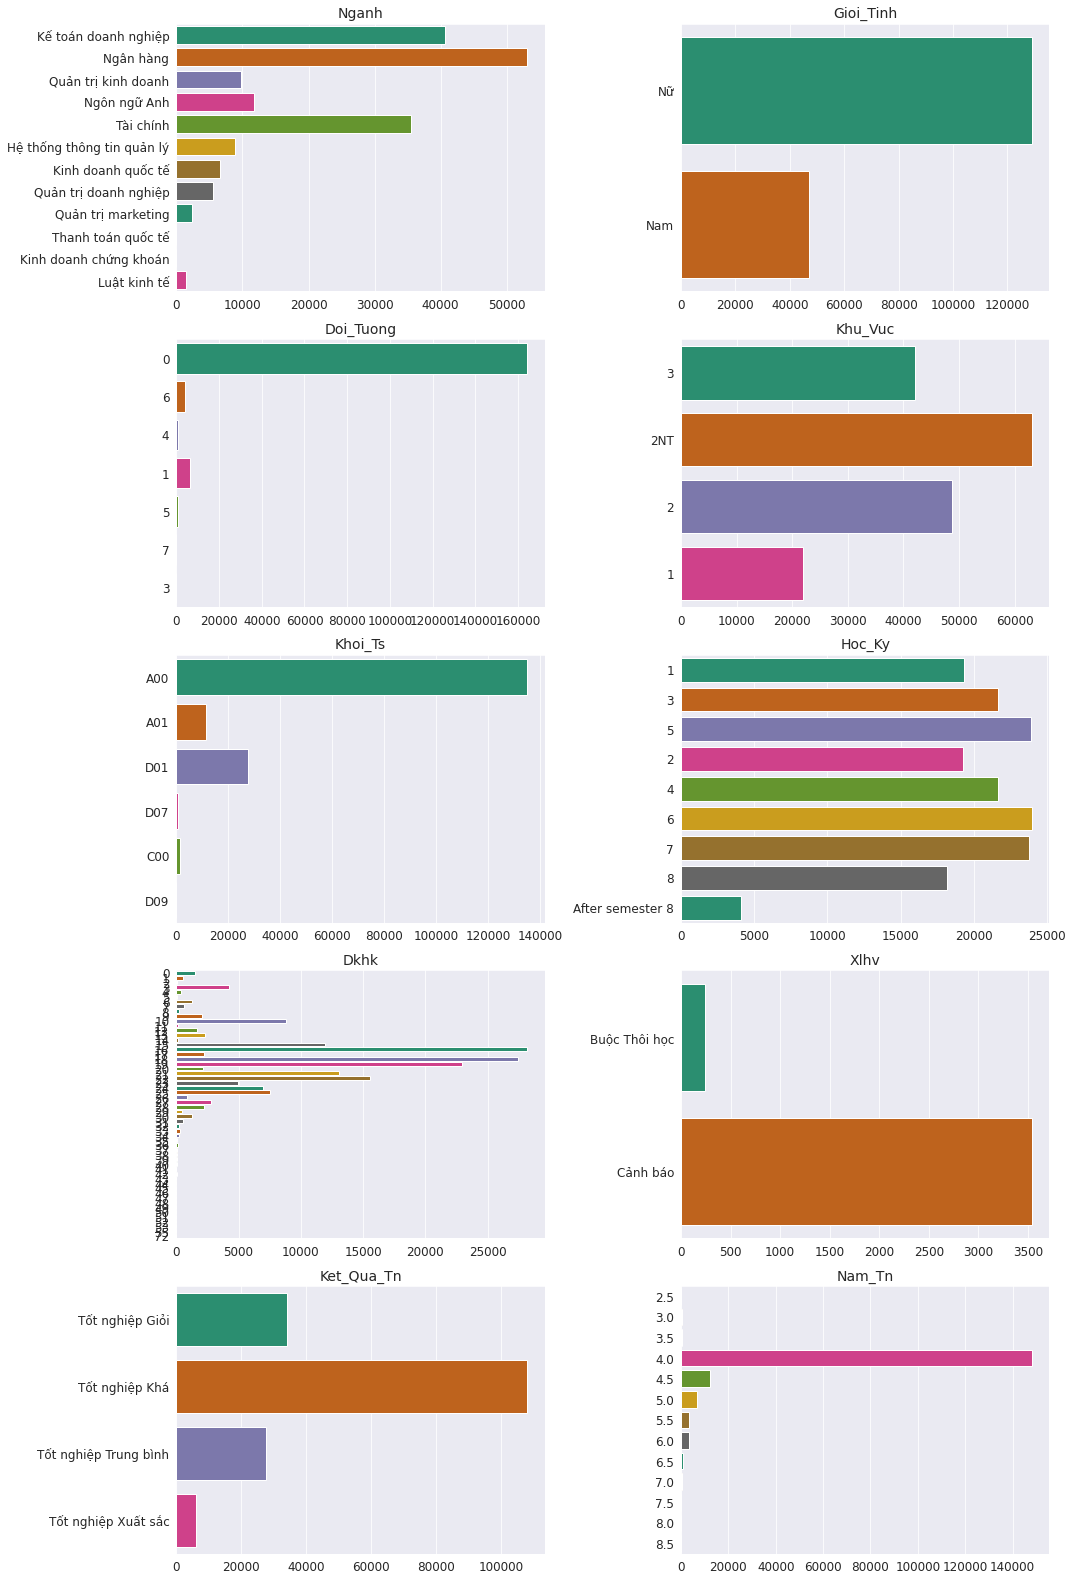

In [61]:
# Sau khi clean
plt.figure(figsize=(15,70))
plotnumber = 1

for col in df.drop(['id', 'diem_tn', 'diem_ts', 'tbhk', 'tctl', 'tbtl'], axis=1):
    if plotnumber <= df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

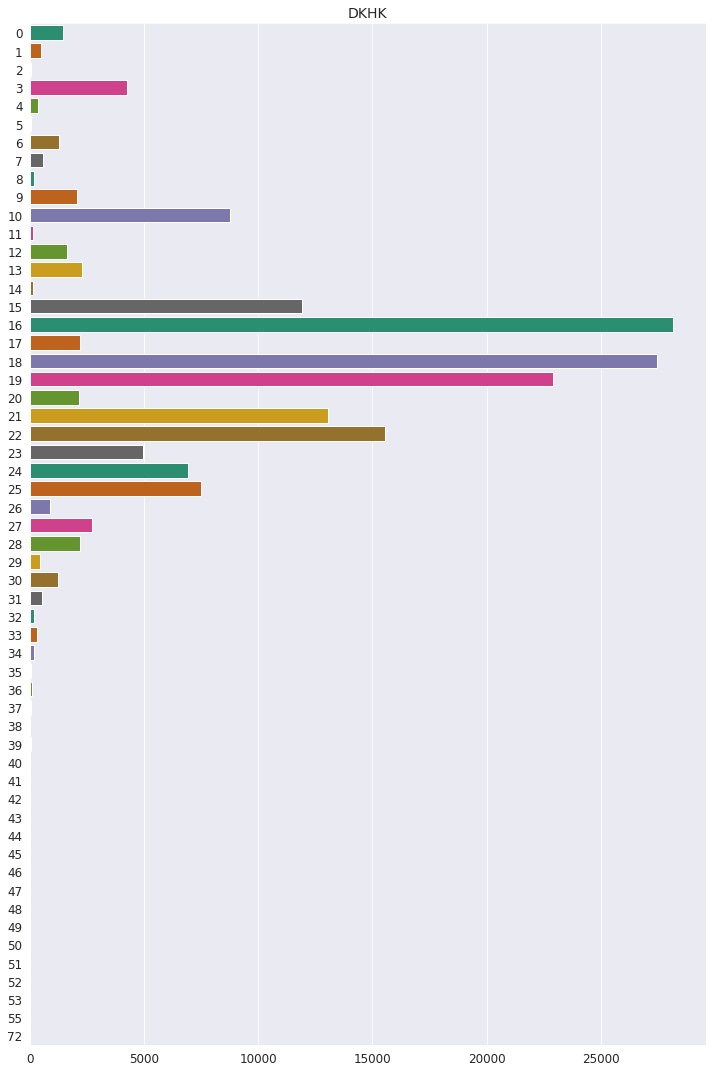

In [ ]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y='dkhk', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('DKHK', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [ ]:
df['dkhk'].unique()

array([22, 16, 19, 13, 25, 18, 23, 28, 20, 26, 17, 32, 29, 21, 24, 27, 15,
       31, 12, 30,  0,  9, 33, 10, 35, 34,  6, 36, 39, 37,  7, 14,  4, 40,
       43,  3, 11, 44,  1, 38,  2, 42, 45, 46,  8, 47, 72, 50, 52, 49, 48,
       51,  5, 55, 41, 53])

In [ ]:
num_cols = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index.tolist()
cat_cols = df.dtypes[(df.dtypes != 'float64') & (df.dtypes != 'int64')].index.tolist()
df[cat_cols]

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,hoc_ky,xlhv,diem_tn,ket_qua,ket_qua_tn,nam_tn
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,1,NaN,3.35,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4 năm
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,1,NaN,2.55,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4 năm
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,1,NaN,3.02,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4 năm
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,1,NaN,2.52,Tốt nghiệp Khá - 4 năm,Tốt nghiệp Khá,4 năm
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,1,NaN,2.09,Tốt nghiệp Trung bình - 4 năm,Tốt nghiệp Trung bình,4 năm
...,...,...,...,...,...,...,...,...,...,...,...,...
198372,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,6,NaN,3.24,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4 năm
198373,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,7,NaN,3.24,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4 năm
198374,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,5,NaN,3.21,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4 năm
198375,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,6,NaN,3.21,Tốt nghiệp Giỏi - 4 năm,Tốt nghiệp Giỏi,4 năm


In [ ]:
df.isna().sum()[df.isna().sum() != 0]

diem_ts       479
tctl           34
xlhv       172060
dtype: int64

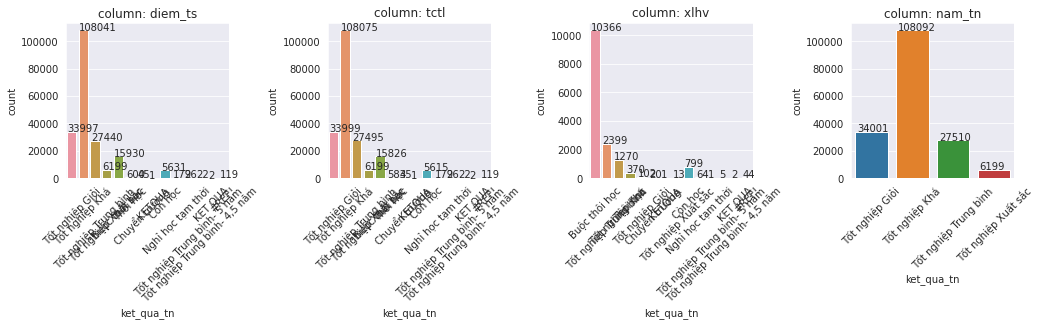

In [ ]:
# fig = plt.figure(figsize = (17,20))
# fig.subplots_adjust(hspace=1, wspace=0.6)
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
# cols = df.isna().sum()[df.isna().sum() != 0].index.tolist()
# for i,col in enumerate(cols):
#     ax = fig.add_subplot(4, 4, i+1)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
#     sns.countplot(x=df.dropna(subset=[col])["ket_qua_tn"])
#     for p in ax.patches:
#       ax.annotate(f'{p.get_height()}', (p.get_x()+0.05, p.get_height()+1))
#     ax.set_title('column: ' + str(col))
# plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
#split the data into train and test set
train, test = train_test_split(df, test_size=0.20, random_state=0)
#save the data
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [62]:
df.to_csv('data_cleaning.csv',index=False)